In [14]:
!pip install tensorflow pandas matplotlib scikit-learn keras


[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [15]:
# Configurar XLA_FLAGS para CUDA
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/lib/cuda'
print("XLA_FLAGS configurado para:", os.environ.get('XLA_FLAGS'))

XLA_FLAGS configurado para: --xla_gpu_cuda_data_dir=/usr/lib/cuda


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Dropout, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [17]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        # Configura para evitar alocar toda memória da GPU
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU configurada para uso com memory growth.")
    except RuntimeError as e:
        print(e)
else:
    print("GPU não encontrada, rodando na CPU.")

GPU configurada para uso com memory growth.


In [18]:
# Carregar dataset
data = np.load('/home/jf/GitRepositories/RedeNeuralArtificial/data/pssm_dataset.npz', allow_pickle=True)
X, y, weights = data['X'], data['y'], data['weights']

print("Shapes ->", X.shape, y.shape, weights.shape)

Shapes -> (126, 754, 20) (126, 754, 3) (126, 754)


In [19]:
# Split
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp, w_train, w_temp = train_test_split(X, y, weights, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test, w_val, w_test = train_test_split(X_temp, y_temp, w_temp, test_size=0.5, random_state=42)

In [20]:
# Modelo CNN
model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),
    Conv1D(64, 5, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(32, activation='tanh'),
    Dropout(0.3),

    Dense(3, activation='softmax')  # Previsão por resíduo
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 754, 64)        │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 754, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 754, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 754, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 754, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 754, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 754, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 754, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 754, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 754, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 754, 3)         │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,371 (165.51 KB)

 Trainable params: 41,987 (164.01 KB)

 Non-trainable params: 384 (1.50 KB)

In [21]:
# Treinamento com máscara
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(
    X_train, y_train,
    sample_weight=w_train,
    validation_data=(X_val, y_val, w_val),
    epochs=30, batch_size=16,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 837ms/step - accuracy: 0.3550 - loss: 0.3794 - val_accuracy: 0.0933 - val_loss: 0.2055 - learning_rate: 0.0010
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4818 - loss: 0.3190 - val_accuracy: 0.1049 - val_loss: 0.1940 - learning_rate: 0.0010
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4955 - loss: 0.2746 - val_accuracy: 0.1220 - val_loss: 0.1873 - learning_rate: 0.0010
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4877 - loss: 0.2738 - val_accuracy: 0.1259 - val_loss: 0.1816 - learning_rate: 0.0010
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5008 - loss: 0.2515 - val_accuracy: 0.9215 - val_loss: 0.1776 - learning_rate: 0.0010
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5234 - loss: 0.2486 - val_accuracy: 0.9236 - val_loss: 0.1732 - learning_rate: 0.0010
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5310 - loss: 0.2422 - val_accuracy: 0.133

In [22]:
# Avaliação
pred = model.predict(X_test)
q3 = np.mean(np.argmax(pred[w_test==1], axis=1) == np.argmax(y_test[w_test==1], axis=1))
print(f"Q3 Score: {q3:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Q3 Score: 0.7098


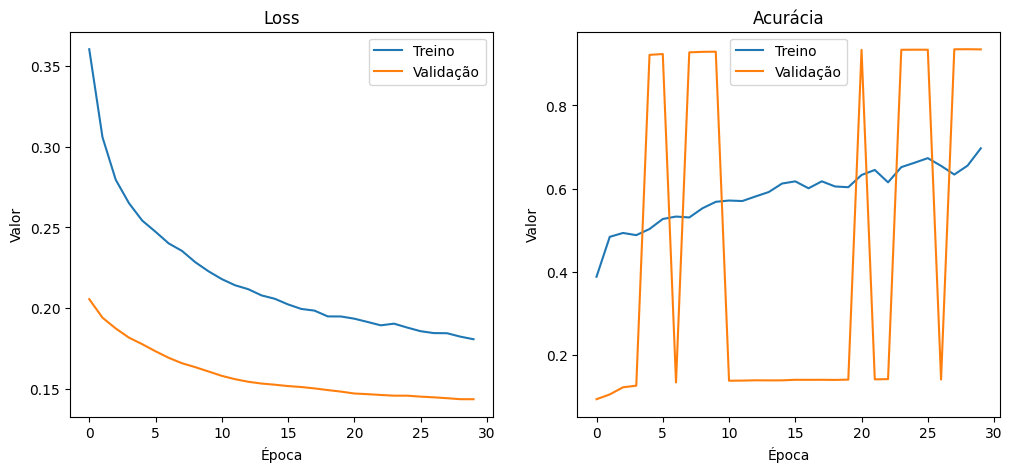

In [23]:
# Curvas de treino e validação
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Loss')
plt.xlabel('Época')
plt.ylabel('Valor')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Época')
plt.ylabel('Valor')
plt.legend()

plt.show()


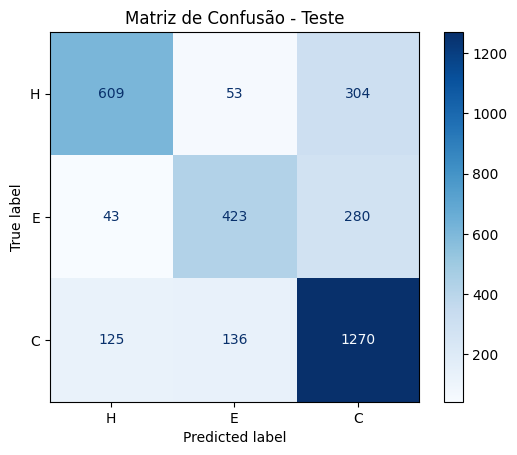

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Converter para classes
true_labels = np.argmax(y_test[w_test==1], axis=1)
pred_labels = np.argmax(pred[w_test==1], axis=1)

# Matriz de confusão
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['H', 'E', 'C'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Teste")
plt.show()


In [25]:
# Escolher índice de sequência no teste
seq_idx = 0

# Predição para essa sequência
pred_seq = np.argmax(pred[seq_idx], axis=1)
true_seq = np.argmax(y_test[seq_idx], axis=1)

# Mapear para letras
mapping = {0: 'H', 1: 'E', 2: 'C'}
true_str = ''.join([mapping[i] for i in true_seq])
pred_str = ''.join([mapping[i] for i in pred_seq])

print("Estrutura real:\n", true_str)
print("\nEstrutura prevista:\n", pred_str)


Estrutura real:
 CCCCCCCCCECCEEECCEEECCCCEEEEEECCCCCHHHHHHHHHHHHHHHHHHHCCCCCCCEEEECCCCHHHHHHHCCCCCCCHHHHHHHHHHCEEEECCCCCCCCCCCCCHHHHHHHHCCCCEEEEEEECCCCCCCCCCCHHHCEEEEEEECCCCHHHCCEECCCCHHHHHHHHHHHHCCCCCCCCCCCCCCEECCCCCHHHHHHHHHHHHHHHHHCCCCEEEEEECCCCCCCCHHHHHHHHHHHHHHHHCCEECCCCCCEEEECCCCCCEEEEEEEEHHHHHHHHHHCHHHCCEEEECHHHHHHHHHHHHHHCCCCCCCEEEEECCCCEEEEECCCCCCCCCCCCCCCCHHHHHHHHHHHHHHCCHHHHHHHHHHHHHHHHCCEECHHHHCCCCCCEECCHHHHHHHHHHCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH

Estrutura prevista:
 CCCCCCCCCCEEEECCCCCECCCCCEEEEECCCCCCCCHHHHHHHHHHHHHCCCCCCCEEEEEEHEECCCCHHHCCCCCCCCCHHHHHHHHHHCEEEECCCCCCCCCCCCCCCCEHHHHCCCEEEECCCEECCCCCCCCCCCCCEEEEEECCCCCCEEECCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCECCCCCCCHH

In [26]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, pred_labels, target_names=['H', 'E', 'C']))


              precision    recall  f1-score   support

           H       0.78      0.63      0.70       966
           E       0.69      0.57      0.62       746
           C       0.69      0.83      0.75      1531

    accuracy                           0.71      3243
   macro avg       0.72      0.68      0.69      3243
weighted avg       0.72      0.71      0.71      3243

